Just like last workshop, let's begin by mounting our Google Drive so we can easily access our dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Again, we will be using NumPy for mathematical operations and Pandas to more easily operate on our dataset. Later, we will introduce another library that will allow us to train a model on our data with relatively straightforward syntax.

In [ ]:
import numpy as np
import pandas as pd

Let's now load our train.csv file into the project.

In [ ]:
# data = pd.read_csv('drive/MyDrive/train.csv', low_memory=False)
data = pd.read_csv('/content/drive/MyDrive/Workshop 1/train.csv', low_memory=False)
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


Our first few steps will be review to some of you. Let's begin by removing columns with lots of missing values, as well as any rows in our remaining columns that contain missing values (recall that the remaining columns contained
less than 100 missing values each, so this step does not significantly impact our data). We see that after completing these steps, there are no missing values remaining in our dataset.

In [ ]:
# Remove columns with lots of missing values
data = data.drop(columns=['WindDirection', 'WindSpeed', 'Temperature', 'GameWeather',
                          'StadiumType', 'Humidity', 'FieldPosition'])

# Remove remaining rows with missing values
data = data.dropna()

# Print missing value counts (there shouldn't be any left at this point)
print("\nMissing Values:")
missing_values = data.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])


Missing Values:
Series([], dtype: int64)


Now, let's drop all other columns that we don't plan on using to train our model (recall that our plan is to predict the number of yards a rusher gains on a play).

In [ ]:
# Drop columns we don't plan on using
data = data.drop(columns=['DisplayName', 'JerseyNumber',
       'Season', 'PossessionTeam', 'PlayerBirthDate', 'PlayerCollegeName',
       'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Week', 'Stadium','TimeSnap', 'TimeHandoff',
       'Location', 'Turf'])

# Print a list of remaining columns
data.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'YardLine', 'Quarter', 'GameClock', 'Down', 'Distance',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'NflIdRusher',
       'OffenseFormation', 'OffensePersonnel', 'DefendersInTheBox',
       'DefensePersonnel', 'PlayDirection', 'Yards', 'PlayerHeight',
       'PlayerWeight'],
      dtype='object')

Before we continue, let's make an important modification to our dataset. In the last workshop, you may recall that when we printed using .head() (i.e., the first 5 rows in the dataset or a specific column), the values in each row were often all the same. This is because for each play, there is a row in the dataset that corresponds to each player. Since there are most often 22 players on the field at a time in the NFL, this means most plays will have 22 rows allocated to them. We see this below (pay attention to the `PlayId` column).

In [ ]:
data.head(25)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,Yards,PlayerHeight,PlayerWeight
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,6-0,212
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,6-3,288
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,6-3,270
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,6-3,245
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,6-0,206
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,6-2,252
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,5-11,190
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,6-0,193
8,2017090700,20170907000118,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,6-2,208
9,2017090700,20170907000118,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,...,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,6-0,197


Since we are specifically trying to predict how many yards the *rusher* gains, let's filter the dataset such that it only contains columns corresponding to the rusher. Take a look at the `PlayId` column in the updated output below.

In [ ]:
data = data.loc[data.NflId == data.NflIdRusher]
data = data.drop(columns = ['NflId', 'NflIdRusher'])
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,Yards,PlayerHeight,PlayerWeight
18,2017090700,20170907000118,home,78.75,30.53,3.63,3.35,0.38,161.98,245.74,...,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,5-10,205
40,2017090700,20170907000139,home,71.07,27.16,3.06,2.41,0.34,210.70,312.20,...,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,3,5-10,205
62,2017090700,20170907000189,home,48.66,19.11,5.77,2.42,0.60,140.82,221.96,...,0,0,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",left,5,5-10,205
84,2017090700,20170907000345,home,15.53,25.36,4.45,3.20,0.46,186.22,275.44,...,0,0,JUMBO,"6 OL, 2 RB, 2 TE, 0 WR",9.0,"4 DL, 4 LB, 3 DB",left,2,5-11,210
98,2017090700,20170907000395,away,29.99,27.12,3.90,2.53,0.44,34.27,157.92,...,7,0,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,7,5-11,216


Let's continue by transforming the data in our remaining columns, starting with the `PlayerHeight` column. Recall that we can convert values like `6-3` to integer values like `75`. Since a maching learning model, in its purest form, is effectively a math equation, we want to feed it values it can interpret (i.e. numbers!).

In [ ]:
def convert_to_inches(height):
    feet, inches = map(int, height.split('-'))
    return feet * 12 + inches

# Apply conversion function and print sample of updated PlayerHeight values
data['PlayerHeight'] = data['PlayerHeight'].apply(convert_to_inches)
data['PlayerHeight'].head()

,PlayerHeight
18,70
40,70
62,70
84,71
98,71


Another step we can take to optimize our data is to combine the information we get from the `Team`, `HomeScoreBeforePlay`, and `VisitorScoreBeforePlay` columns and use them to create a new set of columns: `my_score` and `opponent_score`. This will give our model a clarified understanding of each play without having to make inferences from multiple columns at once to gain the same understanding. The `Team`, `HomeScoreBeforePlay`, and `VisitorScoreBeforePlay` columns on their own aren't particularly useful to our model because without looking at them together, the model can't deduce which score belongs to the team with the ball and which score belongs to the other team.

In [ ]:
# Create new columns 'my_score' and 'opponent_score' out of existing columns
data.loc[data.Team == 'home', 'my_score'] = data.loc[data.Team == 'home', 'HomeScoreBeforePlay']
data.loc[data.Team == 'home', 'opponent_score'] = data.loc[data.Team == 'home', 'VisitorScoreBeforePlay']
data.loc[data.Team == 'away', 'my_score'] = data.loc[data.Team == 'away', 'VisitorScoreBeforePlay']
data.loc[data.Team == 'away', 'opponent_score'] = data.loc[data.Team == 'away', 'HomeScoreBeforePlay']

# Drop existing columns (my_score and opponent_score contain all the information we need from these columns)
data = data.drop(columns = ['HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'Team'])

data.head()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,YardLine,...,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,Yards,PlayerHeight,PlayerWeight,my_score,opponent_score
18,2017090700,20170907000118,78.75,30.53,3.63,3.35,0.38,161.98,245.74,35,...,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,70,205,0.0,0.0
40,2017090700,20170907000139,71.07,27.16,3.06,2.41,0.34,210.70,312.20,43,...,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,3,70,205,0.0,0.0
62,2017090700,20170907000189,48.66,19.11,5.77,2.42,0.60,140.82,221.96,35,...,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",left,5,70,205,0.0,0.0
84,2017090700,20170907000345,15.53,25.36,4.45,3.20,0.46,186.22,275.44,2,...,JUMBO,"6 OL, 2 RB, 2 TE, 0 WR",9.0,"4 DL, 4 LB, 3 DB",left,2,71,210,0.0,0.0
98,2017090700,20170907000395,29.99,27.12,3.90,2.53,0.44,34.27,157.92,25,...,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,7,71,216,0.0,7.0


Here we can see the unique values held in our new columns, `my_score` and `opponent_score`. If you're familiar with football, consider why neither of these columns contain the value `1.0` or even `4.0`.

In [ ]:
print(sorted(data['my_score'].unique()))
print(sorted(data['opponent_score'].unique()))

[0.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 54.0, 57.0, 59.0]
[0.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 54.0, 55.0, 57.0, 59.0]


Next, we create a new set of columns, `Vx` and `Vy`, to represent player velocity. This is essentially speed, except it factors in the player's direction of movement. We then clarify an additional source of potential confusion for our model by modifying our `Vx` values such that every rusher is assumed to move in the same direction. This operation utilizes an otherwise negligible column, `PlayDirection`, which tells us whether play is moving `left` or `right` across the field. We can now remove this column.

In [ ]:
data['Vx'] = data['S'] * np.sin(data['Dir'])
data['Vy'] = data['S'] * np.cos(data['Dir'])

# When play is moving left, flip the sign of Vx
data.loc[data.PlayDirection == 'left', 'Vx'] = data.loc[data.PlayDirection == 'left', 'Vx'] * -1
data.loc[data.PlayDirection == 'left', 'X'] = 120 - data.loc[data.PlayDirection == 'left', 'X']


data = data.drop(columns=['PlayDirection'])

Next, let's take a quick look at the GameClock column.

In [ ]:
data['GameClock'].head()

,GameClock
18,14:14:00
40,13:52:00
62,13:02:00
84,12:12:00
98,12:08:00


In the spirit of converting our column values into their purest numerical representation, let's transform these clock values from strings into decimal form.

In [ ]:
data['GameClock'] = data.GameClock.apply(lambda x: int(x[:2]) + int(x[3:5])/60 + int(x[6:])/60/60)
data['GameClock'].head()

,GameClock
18,14.233333
40,13.866667
62,13.033333
84,12.200000
98,12.133333


Let's now take a look at the `OffenseFormation` column. Again, since our model is essentially a math equation that takes in a bunch of variables, it doesn't make sense for the variable to be a string (ie offensive formation, defensive personnel). So, there's a couple avenues we can take: either encode the data (turns each unique text choice into its own column, with a 1 if that option is present and a 0 if it's not, i.e. One-Hot Encoding), or just keep the column and map it to number (i.e. Label Encoding), which we'll do below. We can do this with the python `enumerate` function, which lets us iterate (go through) each unique offensive formation, as well as it's index (numerical position) in the array, allowing us to assign each formation a unique number.

In [ ]:
formation_mapping = {formation : i for i, formation in enumerate(data.OffenseFormation.unique())} #this line of code maps each formation to a unique number identifier
print(formation_mapping)
data.OffenseFormation = data.OffenseFormation.map(formation_mapping) #map each text entry in the column to its ID, as seen in the formation_mapping dictionary.
data.OffenseFormation.unique()

#additional challenge: process OffensePersonnel and DefensePersonnel


{'SHOTGUN': 0, 'SINGLEBACK': 1, 'JUMBO': 2, 'PISTOL': 3, 'I_FORM': 4, 'ACE': 5, 'WILDCAT': 6, 'EMPTY': 7}


array([0, 1, 2, 3, 4, 5, 6, 7])

The average yards gained per possession by a rusher in the NFL is around 4.4 yards. For the sake of this demonstration, since we'll be using simpler models, lets train a model that will classify whether or not a play, based on pre-handoff data, will gain less or more than 4 yards. Rather, we'll be identifying whether a play is above or below the median. Let's do this by creating a boolean (true or false) column that determines whether each play gains above or below 4 yards, which becomes our target variable.

In [ ]:
data['Yards_above_average'] = data.Yards > 4  #True or False column that tells us whether or not a play is above or below average
data.Yards_above_average = data.Yards_above_average.apply(lambda x: int(x)) #convert from True/False to 0/1
data.Yards_above_average.head()

,Yards_above_average
18,1
40,0
62,1
84,0
98,1


Models:

Now, we will train and use a Logistic Regression model. Without getting too much into the math, "training" a model means finding the best parameters for that model to make a prediction. Essentially, we have an equation that will make a prediction for us. Without training, it's just like flipping a coin; it's not doing anything helpful for our prediction. When we train a model, we can guess these parameters as a starting point and make a guess on our data by comparing what our model outputs to the actual output. Then, we can calculate the error (by looking at many predictions we get wrong), and then adjust those parameters accordingly. There's some math involved behind this that we won't get into, but thankfully by using the Python SciKit-Learn library we can train our model with just one function.

Now, let's choose our features. Below are the features we have included, but you are free to select any combination of these and play around with it. As we mentioned earlier, our target variable is `Yards_above_average` since we're predicting whether or not a running play will result in an above average yardage gain, so you can fill that in below.


In [ ]:
# features = ['X', 'Y', 'A','YardLine', 'Quarter', 'GameClock', 'Down', 'Distance', 'OffenseFormation',
#             'DefendersInTheBox', 'PlayerWeight', 'my_score','opponent_score', 'Vx', 'Vy']
features = ['X', 'Y','YardLine', 'Quarter', 'GameClock', 'Down', 'Distance', 'OffenseFormation',
            'DefendersInTheBox', 'PlayerWeight', 'my_score','opponent_score']

target = #______________ <- fill in here...

X = data[features] #all the pre-handoff data
y = #___________   <- the corresponding result of the play (whether or not the play was above average)

Now, let's split up our data into training and test data. This is a crucial step, because our model will essentially "learn" from the training data by identifying patterns and trends. Once we're done training our model, we also need to evaluate well it performs prediction on unseen data. Generating this data manually would be painstaking and unfeasible, so we just use a portion of our original data that we didn't use for training. Analyzing our model's results on a test dataset, hence, allows us to evaluate the accuracy and precision of our model, as well as its ability to generalize to new data. We do this utilizing the `train_test_split` function from SciKitLearn. You can mess around with the test size, a canonically good split would anywhere around 70% training - 30% test to 80% training - 20% based on the scarcity of the data, but since we have a ton we can start with 80-20.

In [ ]:
from sklearn.model_selection import train_test_split

#this splits our data into X_train and y_train (our training data) and X_test and y_test (our testing data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#mess around with the test_size if you want, don't worry about the random_state


Let's get into the model training and prediction now. We can train our data with just the `fit` function from SciKit-Learn, and for now let's define our model to be a basic logistic regression model. Again, we're gonna use this model as a black box here, but if you're interested in the math feel free to look it up on your own or come up to one of us in the end. Essentially, a logistic regression model will just output a probability that represents the likelihood of the positive outcome (ie above average play, or 1). This probability will always be between 0 and 1; if the probability is greater than 0.5, the model classifies it as a positive outcome (above average play or 1); if it's less than 0.5, it classifies it as a negative outcome (below average play or 0).

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000) #max_iter is how many times you want to adjust your parameters when training. feel free to mess around with this
log_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Our model is now trained. Let's evaluate our results now by using our trained model to make a prediction on the test data. Our prediction will be a list of 0s and 1s for each play, where 0 indicates below average and 1 above average. We can compare our prediction to y_test, which is the actual result.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def print_model_results(model, y_pred):
  print(f"Total 0s and 1s predicted: {np.unique(y_pred, return_counts=True)}")
  print(f"Total 0s and 1s in test set: {np.unique(y_test, return_counts=True)}\n")

  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.2f}\n")

  print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

  proba = model.predict_proba(X_test)
  print(f"Probability of 0 or 1, respectively, for each play: \n{proba}")


y_pred = log_model.predict(X_test)
print_model_results(log_model, y_pred=y_pred)

Total 0s and 1s predicted: (array([0, 1]), array([6022,  179]))
Total 0s and 1s in test set: (array([0, 1]), array([4132, 2069]))

Accuracy: 0.66

Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.98      0.79      4132
           1       0.43      0.04      0.07      2069

    accuracy                           0.66      6201
   macro avg       0.55      0.51      0.43      6201
weighted avg       0.59      0.66      0.55      6201

Probability of 0 or 1, respectively, for each play: 
[[0.62749431 0.37250569]
 [0.64451225 0.35548775]
 [0.76278106 0.23721894]
 ...
 [0.53475352 0.46524648]
 [0.56370924 0.43629076]
 [0.75453476 0.24546524]]


Note that the Classification Report outputs some values that may be difficult to interpret without previous exposure to them. Here is a rundown of what each of them tell us:

*   precision: tells us how many of our predicted positives are actually positives. Inversely related to the number of **false positives**.
*   recall: tells us how many how many positives we correctly predicted out of all the actual positives. Inversely related to the number of **false negatives**.
*   f1-score: combines precision and recall into one metric; gives us an overall measure of the model's performance.




Real World Example: The Seahawks faced a 2nd and 10 at their own 33 yard line, protecting a 4-point lead with 3:38 remaining, Seattle lined up in the I formation, New Orleans put eight defenders in the box.

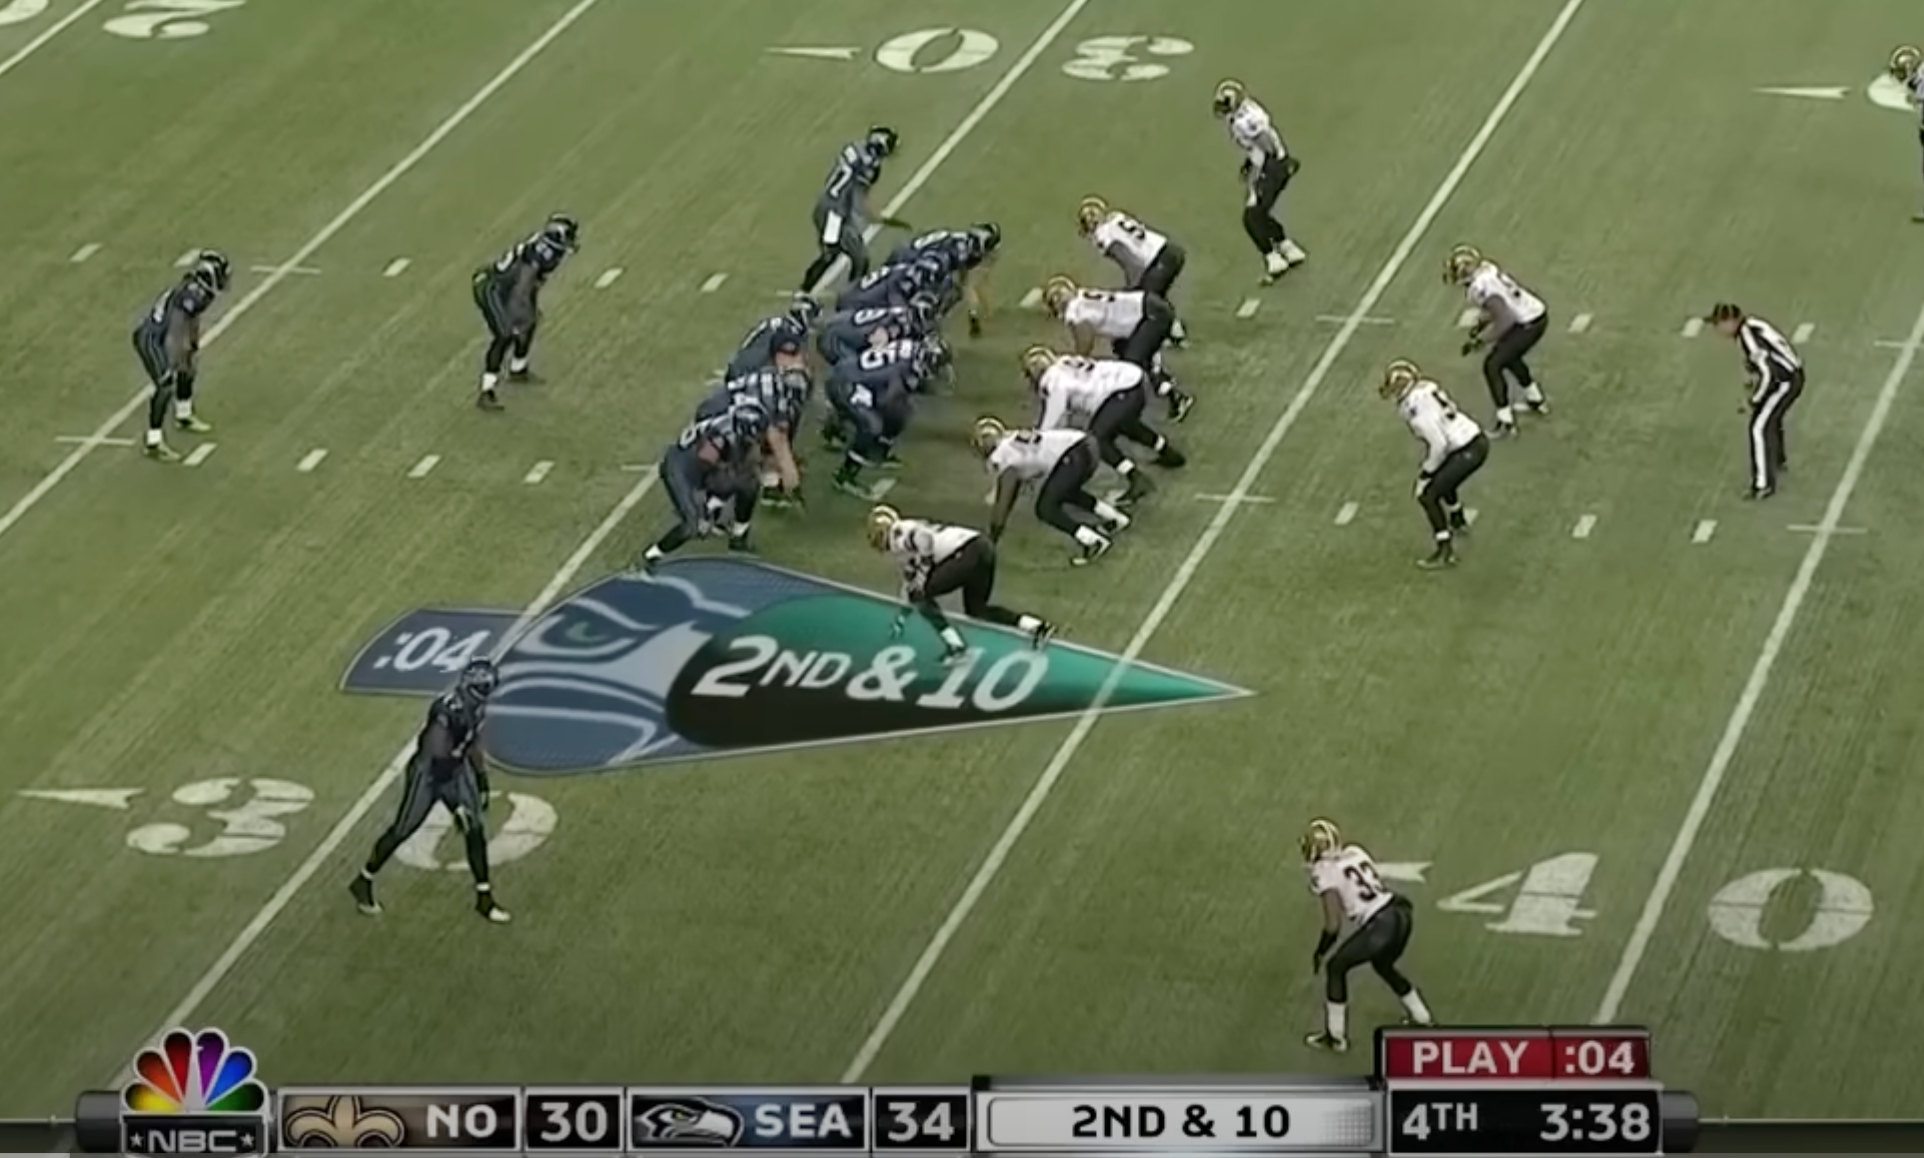

In [ ]:
import numpy as np

beastquake = {
    'X': 33,
    'Y': 30,
    # 'A': 10,
    'YardLine': 33,
    'Quarter': 4,
    'GameClock': 3.38,
    'Down': 2,
    'Distance': 10,
    'OffenseFormation': 4, #I-form
    'DefendersInTheBox': 8,
    'PlayerWeight': 215,
    'my_score': 34,
    'opponent_score': 30,
    # 'Vx': 0.2,
    # 'Vy': -0.3
}

beastquake_df = pd.DataFrame([beastquake])


prediction = log_model.predict(beastquake_df)

print(f'Prediction for the single example: {prediction[0]}')

Prediction for the single example: 0


### Model Prediction
Our model predicted that this play will result in less than 4 yards. Let's watch what actually happened:

[![Watch the Play](https://img.youtube.com/vi/nt0jAa6alUc/0.jpg)](https://www.youtube.com/watch?v=nt0jAa6alUc)


The model correctly predicted that he would gain less than 4 yards!

In [ ]:
taysom = {
    'X': 80,
    'Y': 28,
    # 'A': 10,
    'YardLine': 20,
    'Quarter': 2,
    'GameClock': 7.5,
    'Down': 1,
    'Distance': 10,
    'OffenseFormation': 0, #Shotgun
    'DefendersInTheBox': 4,
    'PlayerWeight': 220,
    'my_score': 7,
    'opponent_score': 17,
    # 'Vx': 0.2,
    # 'Vy': -0.3
}

taysom_df = pd.DataFrame([taysom])


taysom_prediction = log_model.predict(taysom_df)

print(f'Prediction for the single example: {taysom_prediction[0]}')

Prediction for the single example: 1


Now, let's try with some other black box models. The end goal of predicting 0 or 1 is the same, but the math behind getting there is different. Let's try with a `RandomForestClassifier` from SciKitLearn. The Random Foest algorithm works by creating a collection of decision trees that each learn a random subset of the data and features and integrating their unique insights into one model using majority vote or averaging. We can reuse the `print_model_results()` function we defined above to interpret our results.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print_model_results(rf_model, y_pred=y_pred)

Total 0s and 1s predicted: (array([0, 1]), array([5707,  494]))
Total 0s and 1s in test set: (array([0, 1]), array([4132, 2069]))

Accuracy: 0.66

Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.93      0.78      4132
           1       0.43      0.10      0.17      2069

    accuracy                           0.66      6201
   macro avg       0.55      0.52      0.47      6201
weighted avg       0.59      0.66      0.58      6201

Probability of 0 or 1, respectively, for each play: 
[[0.56 0.44]
 [0.55 0.45]
 [0.84 0.16]
 ...
 [0.77 0.23]
 [0.58 0.42]
 [0.78 0.22]]


Another model we can try is `xgboost`. Xgboost also utilizes decision trees, but it builds them sequentially such that each iteration attempts to address the faults of the previous one. Here are the results we get.

In [ ]:
import xgboost as xgb
xg_model = xgb.XGBClassifier()

xg_model #______ fill in code for fitting here (hint: use .fit)
y_pred = #_________ <- fill in here

print_model_results(xg_model, y_pred=y_pred)

Total 0s and 1s predicted: (array([0, 1]), array([5564,  637]))
Total 0s and 1s in test set: (array([0, 1]), array([4132, 2069]))

Accuracy: 0.65

Classification Report: 
              precision    recall  f1-score   support

           0       0.68      0.91      0.77      4132
           1       0.41      0.13      0.19      2069

    accuracy                           0.65      6201
   macro avg       0.54      0.52      0.48      6201
weighted avg       0.59      0.65      0.58      6201

Probability of 0 or 1, respectively, for each play: 
[[0.5659578  0.43404225]
 [0.6874605  0.31253952]
 [0.8450559  0.15494412]
 ...
 [0.69012374 0.30987626]
 [0.41544473 0.58455527]
 [0.7005004  0.29949957]]


Lets look at a confusion matrix and see if we can see if there are any trends with the mistakes that our model is making. Creating a confusion matrix is a common practice in modeling as it allows us to see specifically where the model is becoming confused and how it acts in such scenarios (i.e. what is the model predicting vs what is the true result value).

Confusion matrix
[[3756  376]
 [1808  261]]
Normalized confusion matrix
[[0.9090029 0.0909971]
 [0.8738521 0.1261479]]


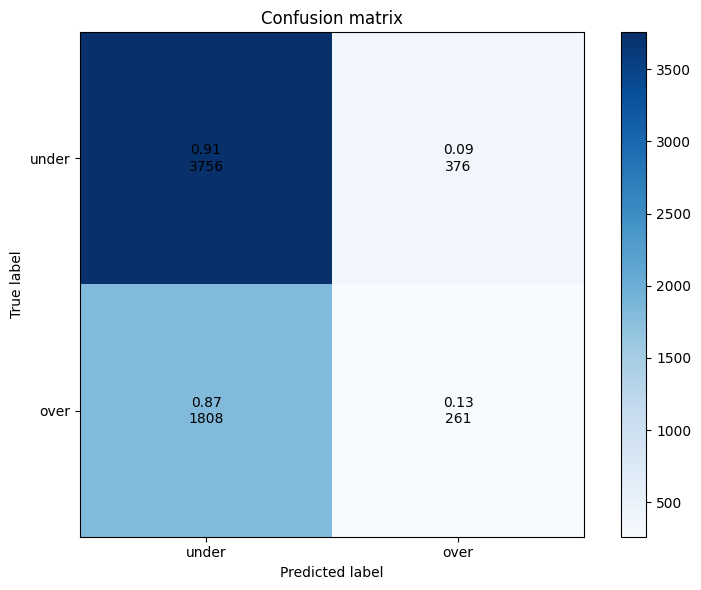

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred)

    print("Confusion matrix")
    print(cm)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    print(cm_normalized)

    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = f"{cm_normalized[i, j]:.2f}\n{cm[i, j]}"
            plt.text(j, i, text,
                     horizontalalignment="center",
                     verticalalignment="center", color='black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

classes = ['under', 'over']

plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_test, y_pred, classes=classes)


As we can see above, all of our models have been predicting significantly more 0s than there are in our test set. This could be a result of the model recognizing that 0s are more frequent in our train dataset, so one way we can address this is by "oversampling" the rows with 1s in the training data.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

xg_oversampled_model = xgb.XGBClassifier()

# Balance the dataset by randomly oversampling the minority class
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

xg_oversampled_model.fit(X_train_resampled, y_train_resampled)
y_pred = xg_oversampled_model.predict(X_test)

print_model_results(xg_oversampled_model, y_pred=y_pred)

Total 0s and 1s predicted: (array([0, 1]), array([3553, 2648]))
Total 0s and 1s in test set: (array([0, 1]), array([4132, 2069]))

Accuracy: 0.56

Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.60      0.64      4132
           1       0.37      0.48      0.42      2069

    accuracy                           0.56      6201
   macro avg       0.54      0.54      0.53      6201
weighted avg       0.59      0.56      0.57      6201

Probability of 0 or 1, respectively, for each play: 
[[0.45747304 0.54252696]
 [0.5388789  0.46112108]
 [0.66208243 0.3379176 ]
 ...
 [0.65057826 0.34942174]
 [0.46397668 0.5360233 ]
 [0.44669443 0.55330557]]


Another option we  have is to adjust the prediction threshold such that our predictions reflect whether the probability of a 1 occurring exceeds a value other than 0.5. In the example below, we set the threshold to 0.47. This will cause the model to predict 1s more frequently, as probability values between 0.47 and 0.5 will be classified as 1s.

In [ ]:
threshold = 0.47
proba = xg_oversampled_model.predict_proba(X_test)[:,0]
y_pred_adjusted = proba < threshold

print_model_results(xg_oversampled_model, y_pred=y_pred_adjusted)

Total 0s and 1s predicted: (array([False,  True]), array([4062, 2139]))
Total 0s and 1s in test set: (array([0, 1]), array([4132, 2069]))

Accuracy: 0.59

Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      4132
           1       0.38      0.40      0.39      2069

    accuracy                           0.59      6201
   macro avg       0.54      0.54      0.54      6201
weighted avg       0.59      0.59      0.59      6201

Probability of 0 or 1, respectively, for each play: 
[[0.45747304 0.54252696]
 [0.5388789  0.46112108]
 [0.66208243 0.3379176 ]
 ...
 [0.65057826 0.34942174]
 [0.46397668 0.5360233 ]
 [0.44669443 0.55330557]]


Confusion matrix
[[2812 1320]
 [1250  819]]
Normalized confusion matrix
[[0.68054211 0.31945789]
 [0.6041566  0.3958434 ]]


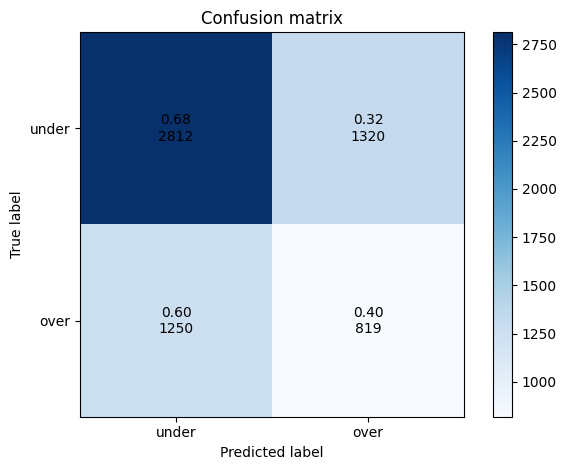

In [ ]:
plot_confusion_matrix(y_test, y_pred_adjusted, classes=classes)

You can also check the amount of influence each feature has on the model's final prediction. If some features have low importance, it could be a good idea to just remove them entirely. Having too many variables as input for a small model could just end up confusing it. Try playing with what features you choose to include and see how it can affect performance!

In [ ]:
def print_feature_importances(model, features):
  featimpdf = pd.DataFrame({
      'feature': features,
      'importance': model.feature_importances_
  })
  featimpdf.sort_values(by='importance', ascending=False, inplace=True)
  featimpdf.reset_index(drop=True, inplace=True)
  print(featimpdf)
print_feature_importances(xg_oversampled_model, features)

              feature  importance
0   DefendersInTheBox    0.161460
1                   X    0.128221
2            YardLine    0.077425
3            Distance    0.077284
4                Down    0.072682
5           GameClock    0.072610
6        PlayerWeight    0.072019
7            my_score    0.069935
8                   Y    0.069188
9    OffenseFormation    0.068965
10            Quarter    0.068257
11     opponent_score    0.061952


Even after trying to account for the class imbalance, the model's performance is still quite poor, as evident in the confusion matrix. While you could continue trying to tune some parameters or playing with the features and data, this problem might ultimately be too difficult for these traditional models to process. Sports are very complex and involve randomness, so simpler models will have a tough time figuring out the subtle patterns.

Deep learning presents a solution to this with larger models involving many times more learnable parameters that are able to fit more complex relationships. However, applying deep learning to simpler problems can also overkill and cause overfitting (memorizing training data and not generalizing).

Another reason for poor performance could be that the data is not good enough, and there just isn't enough information to learn from. Feel free to keep playing with this dataset and these models, and see how much you can improve over us. Have fun!